In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy
import scipy.misc
import os,sys,time,random,glob,pickle
#import theano.sandbox.cuda
#theano.sandbox.cuda.use('gpu0')
import theano
import theano.tensor as T
from lasagne.layers import Conv2DLayer, MaxPool2DLayer, ExpressionLayer, DenseLayer, InputLayer
from lasagne.layers import batch_norm
from lasagne.nonlinearities import rectify, softmax, sigmoid, linear, LeakyRectify
from lasagne.utils import floatX
import lasagne
import random
import pickle
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import cnn_vgg19 as cnn

//anaconda/envs/Python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import scipy.misc

class Batch:
    def __init__(self, trainingFiles, testingFiles):
        open_train, close_train = trainingFiles
        open_test, close_test = testingFiles
        self.open_train = [line.replace('\n', '') for line in open(open_train, 'r')]
        self.close_train = [line.replace('\n', '') for line in open(close_train, 'r')]
        
        self.open_train_num = int(0.9*len(self.open_train))
        self.close_train_num = int(0.9*len(self.close_train))
        
        self.open_train_lst = self.open_train[:self.open_train_num]
        self.close_train_lst = self.close_train[:self.close_train_num]
        
        self.open_val = self.open_train[self.open_train_num:]
        self.close_val = self.close_train[self.close_train_num:]
        
        self.open_test_lst = [line.replace('\n', '') for line in open(open_test, 'r')]
        self.close_test_lst = [line.replace('\n', '') for line in open(close_test, 'r')]
        self.train_open_counter = 0
        self.train_close_counter = 0
        self.test_open_counter = 0
        
    def _image_augment(self, img):
        rand_num = np.random.rand()
        if rand_num < 0.5:
            img = np.flipud(img)
        else:
            img = np.fliplr(img)
        return img
        
    def _read_files(self, files, mode='train'):
        batch_size = len(files)
        imgs = np.zeros((batch_size, 3, 100, 100))
        for f in range(batch_size):
            img_f = files[f]
            img = scipy.misc.imread(img_f)/255.0
            if img.shape[-1] == 4:#some png's have alpha channel
                img = img[:,:,:3]
            #img = scipy.misc.imresize(img, (100, 100))
            if mode == 'train':
                if np.random.rand() > 0.5:
                    imgs[f,:,:,:] = self._image_augment(img.transpose([2, 0, 1]))
                else:
                    imgs[f,:,:,:] = img.transpose([2, 0, 1])
            else:
                imgs[f,:,:,:] = img.transpose([2, 0, 1])
        return imgs
        
        
    def _sample_open_train(self, batch_size):
        target_open = np.ones(batch_size)
        #target_open[:,0] = 1.0
        if self.train_open_counter + batch_size >= len(self.open_train_lst):
            files = self.open_train_lst[self.train_open_counter:len(self.open_train_lst)]
            diff = self.train_open_counter + batch_size - len(self.open_train_lst)
            files = files + self.open_train_lst[:diff]
            self.train_open_counter = diff
        else:
            files = self.open_train_lst[self.train_open_counter:self.train_open_counter + batch_size]
            self.train_open_counter += batch_size
            
        imgs = self._read_files(files)
        return imgs, target_open
    
    def _sample_close_train(self, batch_size):
        target_close = np.zeros(batch_size)
        #target_close[:,1] = 1.0
        if self.train_close_counter + batch_size >= len(self.close_train_lst):
            files = self.close_train_lst[self.train_close_counter:len(self.close_train_lst)]
            diff = self.train_close_counter + batch_size - len(self.close_train_lst)
            files = files + self.close_train_lst[:diff]
            self.train_close_counter = diff
        else:
            files = self.close_train_lst[self.train_close_counter:self.train_close_counter + batch_size]
            self.train_close_counter += batch_size
            
        imgs = self._read_files(files)
        return imgs, target_close
    
    def sample_train_batch(self, batch_size):
        imgs_open, targets_open = self._sample_open_train(int(batch_size/2))
        imgs_close, targets_close = self._sample_close_train(int(batch_size/2))
        imgs = np.concatenate((imgs_open, imgs_close))
        targets = np.concatenate((targets_open, targets_close))
        return imgs.astype(np.float32), targets.astype(np.float32)
    
    def get_val_set(self, batch_size):
        
        open_imgs = self._read_files(self.open_val[:batch_size])
        close_imgs = self._read_files(self.close_val[:batch_size])
        num_open_val = len(self.open_val)
        num_close_val = len(self.close_val)
        open_target = np.ones(batch_size)
        close_target = np.zeros(batch_size)
        imgs = np.concatenate((close_imgs, open_imgs))
        targets = np.concatenate((close_target, open_target))
        return imgs.astype(np.float32), targets.astype(np.float32)
    
    def get_test_set(self):
        imgs_open = self._read_files(self.open_test_lst, mode=None)
        imgs_close = self._read_files(self.close_test_lst, mode=None)
        targets_open = np.ones(len(self.open_test_lst))
        targets_close = np.zeros(len(self.close_test_lst))
        imgs = np.concatenate((imgs_open, imgs_close))
        targets = np.concatenate((targets_open, targets_close))
        return imgs.astype(np.float32), targets.astype(np.float32)
    
        
        

In [3]:
input_img = T.ftensor4('input_imgs')
targets = T.vector('targets')
lrate = theano.shared(floatX(0.0001))

#net = cnn.build_vggnet(input_img)
#net = cnn.freeze_layers(net, 'pool5')
net = cnn.new_cnn(input_img)

prediction = lasagne.layers.get_output(net['output'])

#cross_entropy_loss = lasagne.objectives.aggregate(lasagne.objectives.categorical_crossentropy(prediction, targets))

cross_entropy_loss = lasagne.objectives.binary_crossentropy(prediction, targets).mean()


net_params = lasagne.layers.get_all_params(net['output'], trainable=True)

updates_adam = lasagne.updates.adam(cross_entropy_loss, net_params, learning_rate=lrate)

train_net = theano.function([input_img, targets], 
                            cross_entropy_loss, updates=updates_adam)

prediction_det = lasagne.layers.get_output(net['output'], deterministic=True)

accuracy = T.mean(lasagne.objectives.binary_accuracy(prediction_det, targets))

accuracy_fn = theano.function([input_img, targets], accuracy)

out_fn = theano.function([input_img], prediction_det)

KeyboardInterrupt: 

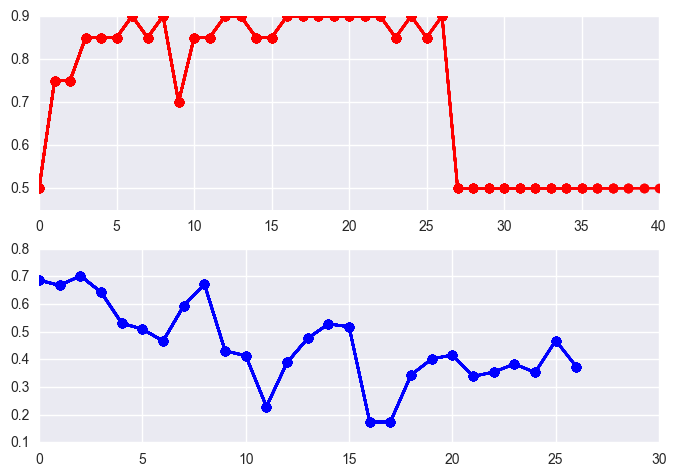

In [4]:
epochs = 1000

trainingFiles = ('./open_train.txt', './close_train.txt')
testFiles = ('./open_test.txt', './close_test.txt')

batch = Batch(trainingFiles, testFiles)
accuracies = []
losses = []
max_acc = 0.0
for epoch in range(epochs):
    for j in range(100):
        imgs, img_targets = batch.sample_train_batch(10)
        loss = train_net(imgs, img_targets)
    val_img, val_target = batch.get_val_set(10)
    acc = accuracy_fn(val_img, val_target)
    if acc > max_acc:
        max_acc = acc
        net_params = lasagne.layers.get_all_param_values(net['output'])
        pickle.dump(net_params, open('new_cnn_weights', 'wb'))
    accuracies.append(acc)
    losses.append(loss)
    plt.subplot('211')
    plt.plot(accuracies, 'ro-')
    plt.subplot('212')
    plt.plot(losses, 'bo-')
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [5]:
trainingFiles = ('./open_train.txt', './close_train.txt')
testFiles = ('./open_test.txt', './close_test.txt')

params = lasagne.layers.get_all_params(net['output'])
values = pickle.load(open('new_cnn_weights'))
for p, v in zip(params, values):
    p.set_value(v)

batch1 = Batch(trainingFiles, testFiles)
test_imgs, test_targets = batch1.get_test_set()
print(accuracy_fn(test_imgs, test_targets))

0.748971193416


In [ ]:
out
img_f = 'dataset_B_FacialImages/OpenFace/Pascal_Affi_Nguessan_0001.jpg'
img = scipy.misc.imread(img_f)/255.0
img_t = np.expand_dims(img.transpose([2,0,1]), 0)

In [ ]:
layer_out = lasagne.layers.get_output(net['output']).eval({input_img:img_t.astype(np.float32)})

In [ ]:
layer_out